In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from ae_eval_and_vis import *
from ae_torch_classes import *
from preprocessing import *
from ml_pipeline import *

# Load in Data

In [2]:
# remove pID 101 because it doesn't exist
# remove pID 131 because it  doesnt have enough user defined gestures
# each participant has 100 experimenter defined files and 50 user defined files
# 10 experimenter defined gestures and 5 user defined gestures

file_types = ["IMU_extract", "movavg_files"]
expt_types = ["experimenter-defined"]

#remove participant 131 because they are missing gestures 
pIDs_impaired = ['P102','P103','P104','P105','P106','P107','P108','P109','P110','P111',
       'P112','P114','P115','P116','P118','P119','P121','P122','P123','P124','P125',
       'P126','P127','P128', 'P132']
# remove participants P001 and P003 because they dont have duplicate or open gestures
pIDs_unimpaired = ['P004','P005','P006','P008','P010','P011']

pIDs_both = pIDs_impaired + pIDs_unimpaired

In [5]:
# Kai's laptop
data_path = "C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\Filtered_Datasets\\"
# BRC Desktop
#data_path = "D:\\Kai_MetaGestureClustering_24\\saved_datasets\\"

print("Loading")

metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']
metadata_cols_df = pd.read_pickle('C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\metadata_cols_df.pkl')

full_emg_XY_df = pd.read_pickle(data_path+'metadata_EMG_allgestures_allusers.pkl')


Loading


In [6]:
print(full_emg_XY_df.shape)
full_emg_XY_df.head()

(427008, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,0.000002,0.000002,0.000001,0.000002,0.000003,0.000004,0.000002,0.000002,0.000003,0.000020,0.000004,0.000004,0.000002,0.000009,0.000001,0.000002
1,P102,pan,1,0.000002,0.000002,0.000001,0.000002,0.000003,0.000005,0.000003,0.000003,0.000003,0.000014,0.000007,0.000007,0.000002,0.000017,0.000001,0.000002
2,P102,pan,1,0.000002,0.000002,0.000001,0.000002,0.000004,0.000005,0.000003,0.000003,0.000004,0.000007,0.000004,0.000005,0.000003,0.000020,0.000003,0.000002
3,P102,pan,1,0.000002,0.000002,0.000002,0.000002,0.000005,0.000006,0.000003,0.000003,0.000006,0.000005,0.000004,0.000003,0.000004,0.000015,0.000003,0.000003
4,P102,pan,1,0.000003,0.000002,0.000002,0.000002,0.000005,0.000007,0.000003,0.000002,0.000008,0.000003,0.000007,0.000022,0.000004,0.000017,0.000002,0.000003


Mean subtract

In [13]:
print("Started")
start_time = time.time()
full_emg_ms_XY_df = meansubtract_df_by_gesture(full_emg_XY_df)
print(f"Completed in {time.time() - start_time}s")

Started
Completed in 46.34801888465881s


Need to do the train test split...

In [14]:
# Held out useres from NB 003
held_out_user_pids = ['P103','P109','P114','P124','P128','P004','P010']

In [15]:
print(full_emg_ms_XY_df.shape)
full_emg_ms_XY_df.head()

(427008, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.000002,-0.000004,-0.000002,-1.073814e-06,-1.116413e-06,-2.553807e-06,-1.519137e-06,-1.470037e-07,-4.804797e-06,-0.000006,-3.194128e-06,-3.955994e-06,-2.761547e-06,-0.000010,-7.029408e-07,-5.178945e-07
1,P102,pan,1,-0.000002,-0.000004,-0.000002,-8.509894e-07,-7.256465e-07,-1.623119e-06,-6.918069e-07,4.930801e-07,-4.487795e-06,-0.000011,-3.454802e-08,-7.666755e-07,-2.022076e-06,-0.000001,-6.147716e-07,-2.144813e-07
2,P102,pan,1,-0.000002,-0.000004,-0.000002,-4.696176e-07,9.637207e-08,-1.130861e-06,-3.763653e-07,6.437183e-07,-3.674076e-06,-0.000019,-2.892269e-06,-2.629805e-06,-1.651926e-06,0.000001,6.229549e-07,2.599464e-08
3,P102,pan,1,-0.000002,-0.000004,-0.000002,-4.026151e-07,1.007132e-06,5.100669e-08,-3.238861e-07,4.452346e-07,-2.333567e-06,-0.000020,-3.138945e-06,-4.262033e-06,-7.956578e-07,-0.000003,8.054968e-07,1.099523e-06
4,P102,pan,1,-0.000001,-0.000004,-0.000002,-4.505710e-07,1.237094e-06,5.680802e-07,-2.160070e-08,2.283233e-07,-9.088692e-08,-0.000022,-7.021894e-07,1.475079e-05,-7.793838e-07,-0.000001,-1.959684e-07,9.493486e-07


In [17]:
test_users_df = full_emg_ms_XY_df[full_emg_ms_XY_df['Participant'].isin(held_out_user_pids)]

print(test_users_df.shape)
test_users_df.head()

(99648, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
11520,P103,gesture-1,1,-0.000019,-0.000005,-0.000004,-0.000006,-0.000004,-0.000001,-6.059202e-07,-8.070082e-07,-0.000042,-0.000005,-0.000003,-0.000005,-0.000016,-0.000013,4.672679e-07,-8.807366e-07
11521,P103,gesture-1,1,-0.000019,-0.000005,-0.000004,-0.000007,-0.000004,-0.000001,-5.060720e-07,-2.247481e-06,-0.000041,-0.000005,-0.000003,-0.000005,-0.000016,-0.000013,-4.303395e-07,-6.558262e-07
11522,P103,gesture-1,1,-0.000019,-0.000005,-0.000004,-0.000008,-0.000004,-0.000001,-7.511665e-07,-1.908100e-06,-0.000041,-0.000005,-0.000003,-0.000005,-0.000017,-0.000013,-1.724456e-06,-5.242660e-07
11523,P103,gesture-1,1,-0.000019,-0.000005,-0.000004,-0.000006,-0.000004,-0.000001,-4.902269e-07,-3.284538e-06,-0.000042,-0.000005,-0.000003,-0.000005,-0.000016,-0.000013,6.681349e-07,-4.605877e-07
11524,P103,gesture-1,1,-0.000018,-0.000005,-0.000004,-0.000006,-0.000004,-0.000001,-5.543854e-07,-2.877587e-06,-0.000042,-0.000005,-0.000003,-0.000005,-0.000016,-0.000013,1.610386e-07,-7.220098e-07


In [19]:
# Merge the DataFrames with an indicator
merged_df = full_emg_ms_XY_df.merge(test_users_df, how='left', indicator=True)
# Filter out the rows that are in both DataFrames
training_users_df = merged_df[merged_df['_merge'] == 'left_only'].drop(columns='_merge')

print(training_users_df.shape)
training_users_df.head()

(327360, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.000002,-0.000004,-0.000002,-1.073814e-06,-1.116413e-06,-2.553807e-06,-1.519137e-06,-1.470037e-07,-4.804797e-06,-0.000006,-3.194128e-06,-3.955994e-06,-2.761547e-06,-0.000010,-7.029408e-07,-5.178945e-07
1,P102,pan,1,-0.000002,-0.000004,-0.000002,-8.509894e-07,-7.256465e-07,-1.623119e-06,-6.918069e-07,4.930801e-07,-4.487795e-06,-0.000011,-3.454802e-08,-7.666755e-07,-2.022076e-06,-0.000001,-6.147716e-07,-2.144813e-07
2,P102,pan,1,-0.000002,-0.000004,-0.000002,-4.696176e-07,9.637207e-08,-1.130861e-06,-3.763653e-07,6.437183e-07,-3.674076e-06,-0.000019,-2.892269e-06,-2.629805e-06,-1.651926e-06,0.000001,6.229549e-07,2.599464e-08
3,P102,pan,1,-0.000002,-0.000004,-0.000002,-4.026151e-07,1.007132e-06,5.100669e-08,-3.238861e-07,4.452346e-07,-2.333567e-06,-0.000020,-3.138945e-06,-4.262033e-06,-7.956578e-07,-0.000003,8.054968e-07,1.099523e-06
4,P102,pan,1,-0.000001,-0.000004,-0.000002,-4.505710e-07,1.237094e-06,5.680802e-07,-2.160070e-08,2.283233e-07,-9.088692e-08,-0.000022,-7.021894e-07,1.475079e-05,-7.793838e-07,-0.000001,-1.959684e-07,9.493486e-07


Now can break it up into data and labels

In [20]:
emg_gesture_train_labels_df = training_users_df['Gesture_ID']
emg_gesture_test_labels_df = test_users_df['Gesture_ID']
emg_user_train_labels_df = training_users_df['Participant']
emg_user_test_labels_df = test_users_df['Participant']
emg_training_users_df = training_users_df.drop(metadata_cols, axis=1)
emg_test_users_df = test_users_df.drop(metadata_cols, axis=1)

In [21]:
print(emg_gesture_train_labels_df.shape)
emg_gesture_train_labels_df.head()

(327360,)


0    pan
1    pan
2    pan
3    pan
4    pan
Name: Gesture_ID, dtype: object

In [22]:
print(emg_training_users_df.shape)
emg_training_users_df.head()

(327360, 16)


,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,-0.000002,-0.000004,-0.000002,-1.073814e-06,-1.116413e-06,-2.553807e-06,-1.519137e-06,-1.470037e-07,-4.804797e-06,-0.000006,-3.194128e-06,-3.955994e-06,-2.761547e-06,-0.000010,-7.029408e-07,-5.178945e-07
1,-0.000002,-0.000004,-0.000002,-8.509894e-07,-7.256465e-07,-1.623119e-06,-6.918069e-07,4.930801e-07,-4.487795e-06,-0.000011,-3.454802e-08,-7.666755e-07,-2.022076e-06,-0.000001,-6.147716e-07,-2.144813e-07
2,-0.000002,-0.000004,-0.000002,-4.696176e-07,9.637207e-08,-1.130861e-06,-3.763653e-07,6.437183e-07,-3.674076e-06,-0.000019,-2.892269e-06,-2.629805e-06,-1.651926e-06,0.000001,6.229549e-07,2.599464e-08
3,-0.000002,-0.000004,-0.000002,-4.026151e-07,1.007132e-06,5.100669e-08,-3.238861e-07,4.452346e-07,-2.333567e-06,-0.000020,-3.138945e-06,-4.262033e-06,-7.956578e-07,-0.000003,8.054968e-07,1.099523e-06
4,-0.000001,-0.000004,-0.000002,-4.505710e-07,1.237094e-06,5.680802e-07,-2.160070e-08,2.283233e-07,-9.088692e-08,-0.000022,-7.021894e-07,1.475079e-05,-7.793838e-07,-0.000001,-1.959684e-07,9.493486e-07


In [23]:
print(emg_gesture_test_labels_df.shape)
emg_gesture_test_labels_df.head()

(99648,)


11520    gesture-1
11521    gesture-1
11522    gesture-1
11523    gesture-1
11524    gesture-1
Name: Gesture_ID, dtype: object

In [24]:
print(emg_test_users_df.shape)
emg_test_users_df.head()

(99648, 16)


,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
11520,-0.000019,-0.000005,-0.000004,-0.000006,-0.000004,-0.000001,-6.059202e-07,-8.070082e-07,-0.000042,-0.000005,-0.000003,-0.000005,-0.000016,-0.000013,4.672679e-07,-8.807366e-07
11521,-0.000019,-0.000005,-0.000004,-0.000007,-0.000004,-0.000001,-5.060720e-07,-2.247481e-06,-0.000041,-0.000005,-0.000003,-0.000005,-0.000016,-0.000013,-4.303395e-07,-6.558262e-07
11522,-0.000019,-0.000005,-0.000004,-0.000008,-0.000004,-0.000001,-7.511665e-07,-1.908100e-06,-0.000041,-0.000005,-0.000003,-0.000005,-0.000017,-0.000013,-1.724456e-06,-5.242660e-07
11523,-0.000019,-0.000005,-0.000004,-0.000006,-0.000004,-0.000001,-4.902269e-07,-3.284538e-06,-0.000042,-0.000005,-0.000003,-0.000005,-0.000016,-0.000013,6.681349e-07,-4.605877e-07
11524,-0.000018,-0.000005,-0.000004,-0.000006,-0.000004,-0.000001,-5.543854e-07,-2.877587e-06,-0.000042,-0.000005,-0.000003,-0.000005,-0.000016,-0.000013,1.610386e-07,-7.220098e-07


Set up dataloaders for the AEs

In [ ]:
num_rows_per_gesture = 64 # From the interp
batch_size = 32  # Adjust batch size as needed

In [35]:
emg_train_loader = create_dataloader(emg_training_users_df, GestureDatasetAE)
emg_test_loader = create_dataloader(emg_test_users_df, GestureDatasetAE)

In [34]:
# Create an iterator from the DataLoader
train_loader_iter = iter(emg_train_loader)
# Get the first batch
first_batch = next(train_loader_iter)
data = first_batch

print("Data type:", type(data))
print("Data shape:", data.shape)

Data type: <class 'torch.Tensor'>
Data shape: torch.Size([32, 64, 16])


In [36]:
# Create an iterator from the DataLoader
test_loader_iter = iter(emg_test_loader)
# Get the first batch
first_batch = next(test_loader_iter)
data = first_batch

print("Data type:", type(data))
print("Data shape:", data.shape)

Data type: <class 'torch.Tensor'>
Data shape: torch.Size([32, 64, 16])


Now finally train some AEs (just basic RNN AEs for now)

In [40]:
# Kai:
model_dir_path = 'C:\\Users\\kdmen\\Desktop\\Research\\Repos\\fl-gestures\\models\\'
# BRC:
#model_dir_path = 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\'

input_dim = 16
seq_len = 64
criterion = nn.MSELoss()
num_epochs = 10

Started
Epoch 0: Train Loss: 0.0017530477348827844;  Validation Loss: 9.680606620219936e-05
Epoch 1: Train Loss: 5.376712682618745e-05;  Validation Loss: 2.7942463930230588e-05
Epoch 2: Train Loss: 1.852127207939702e-05;  Validation Loss: 1.2347772191825076e-05
Epoch 3: Train Loss: 9.390567754508083e-06;  Validation Loss: 7.1034597957415305e-06
Epoch 4: Train Loss: 5.66411309250725e-06;  Validation Loss: 4.45790428970287e-06
Epoch 5: Train Loss: 3.616196485722867e-06;  Validation Loss: 2.888597687067849e-06
Epoch 6: Train Loss: 2.3606685886079504e-06;  Validation Loss: 1.8988560357832527e-06
Epoch 7: Train Loss: 1.5600498436185716e-06;  Validation Loss: 1.2627560933224789e-06
Epoch 8: Train Loss: 1.0451540024547512e-06;  Validation Loss: 8.542137449267659e-07
Epoch 9: Train Loss: 7.153605540821673e-07;  Validation Loss: 5.933173453313986e-07


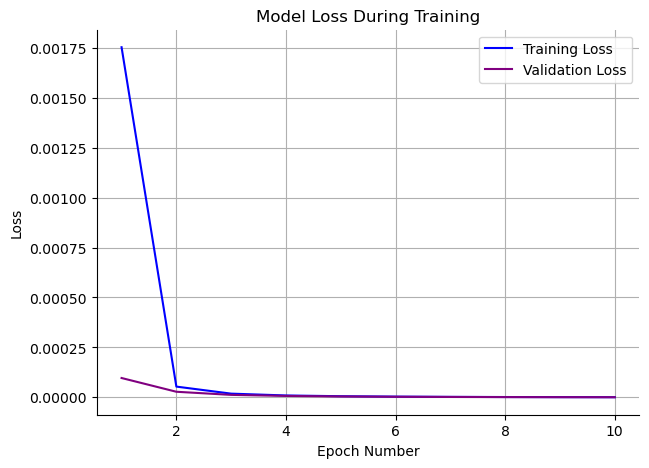

In [42]:
print("Started")
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [20, 10]
model_20_10mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, emg_train_loader, emg_test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.0025964077142589304;  Validation Loss: 5.296959783181035e-05
Epoch 1: Train Loss: 3.3025302047917646e-05;  Validation Loss: 2.0014965805469784e-05
Epoch 2: Train Loss: 1.4021318281720597e-05;  Validation Loss: 9.628035922086921e-06
Epoch 3: Train Loss: 7.190999801309772e-06;  Validation Loss: 5.26372034481919e-06
Epoch 4: Train Loss: 4.053893155742116e-06;  Validation Loss: 3.0568940715335085e-06
Epoch 5: Train Loss: 2.3967139775038504e-06;  Validation Loss: 1.843848081636902e-06
Epoch 6: Train Loss: 1.4708396747664664e-06;  Validation Loss: 1.1560938980196346e-06
Epoch 7: Train Loss: 9.418832370045038e-07;  Validation Loss: 7.597352636162677e-07
Epoch 8: Train Loss: 6.345090586279412e-07;  Validation Loss: 5.267388216304184e-07
Epoch 9: Train Loss: 4.51525563427424e-07;  Validation Loss: 3.856797687204766e-07


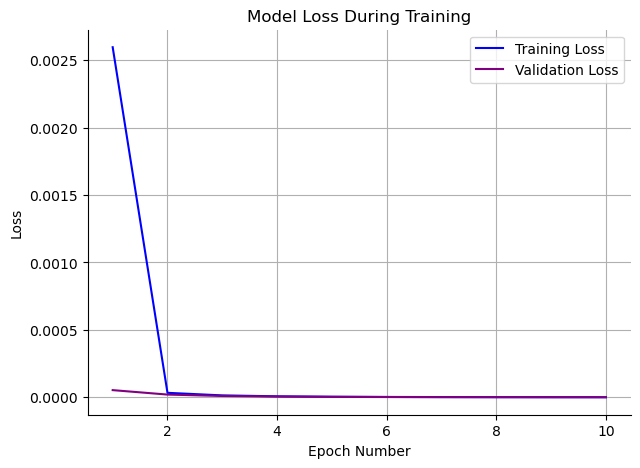

In [44]:
print("Started")
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [20, 10, 3]
model_20_10_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, emg_train_loader, emg_test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.006232761950650456;  Validation Loss: 0.00012036289634273331
Epoch 1: Train Loss: 9.315594488725764e-05;  Validation Loss: 7.001763017852886e-05
Epoch 2: Train Loss: 5.470240421345807e-05;  Validation Loss: 4.212268634416562e-05
Epoch 3: Train Loss: 3.392665749970547e-05;  Validation Loss: 2.71243696595181e-05
Epoch 4: Train Loss: 2.2518607886468088e-05;  Validation Loss: 1.859822994595802e-05
Epoch 5: Train Loss: 1.5796981875837447e-05;  Validation Loss: 1.3349315293230667e-05
Epoch 6: Train Loss: 1.1516858666027475e-05;  Validation Loss: 9.883213351713493e-06
Epoch 7: Train Loss: 8.618771542501235e-06;  Validation Loss: 7.475506923323597e-06
Epoch 8: Train Loss: 6.570243715486867e-06;  Validation Loss: 5.743580514922077e-06
Epoch 9: Train Loss: 5.078742574937678e-06;  Validation Loss: 4.467258646882885e-06


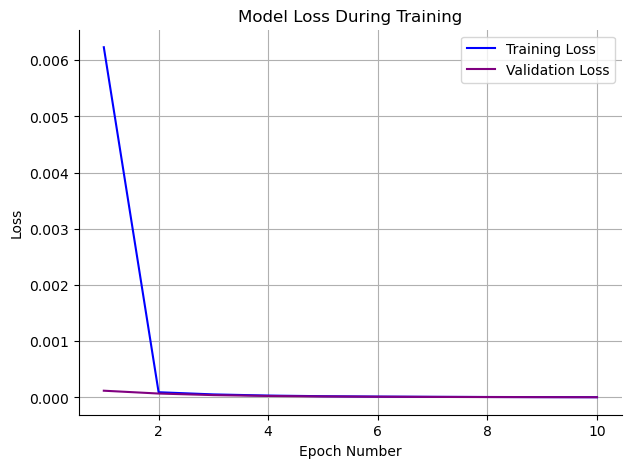

In [45]:
print("Started")
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [12, 10]
model_12_10mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, emg_train_loader, emg_test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.01961695835543651;  Validation Loss: 0.0002801895078642256
Epoch 1: Train Loss: 0.00017816423542171833;  Validation Loss: 0.0001343179200728405
Epoch 2: Train Loss: 0.00010893675662373425;  Validation Loss: 8.662478663906341e-05
Epoch 3: Train Loss: 7.004128849530389e-05;  Validation Loss: 5.5497569018352436e-05
Epoch 4: Train Loss: 4.482567981085594e-05;  Validation Loss: 3.554601500247966e-05
Epoch 5: Train Loss: 2.885458017090059e-05;  Validation Loss: 2.3078839668804513e-05
Epoch 6: Train Loss: 1.895781012990483e-05;  Validation Loss: 1.540770686655638e-05
Epoch 7: Train Loss: 1.2869069871612738e-05;  Validation Loss: 1.067123547708972e-05
Epoch 8: Train Loss: 9.075342364894823e-06;  Validation Loss: 7.678786330091367e-06
Epoch 9: Train Loss: 6.64000093024697e-06;  Validation Loss: 5.718430295056183e-06


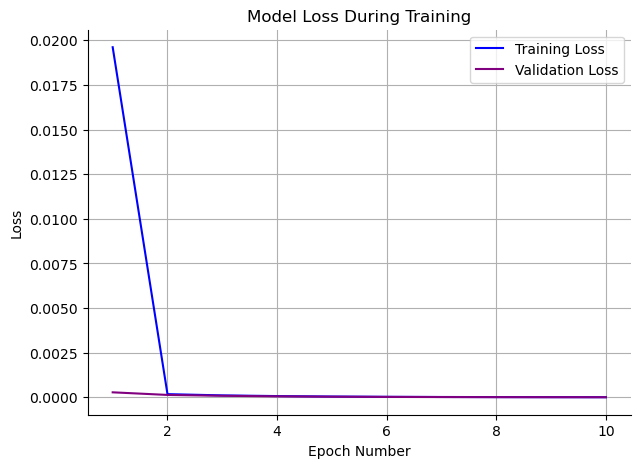

In [46]:
print("Started")
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [10]
model_10mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, emg_train_loader, emg_test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.006634677960755652;  Validation Loss: 0.0001737102037604556
Epoch 1: Train Loss: 0.00012561118123812775;  Validation Loss: 9.085858886353481e-05
Epoch 2: Train Loss: 7.145084812236746e-05;  Validation Loss: 5.574813592235786e-05
Epoch 3: Train Loss: 4.496056130847137e-05;  Validation Loss: 3.553729239145617e-05
Epoch 4: Train Loss: 2.8492037722571693e-05;  Validation Loss: 2.229548111672e-05
Epoch 5: Train Loss: 1.7769177173931893e-05;  Validation Loss: 1.3868488854406715e-05
Epoch 6: Train Loss: 1.1128057855103179e-05;  Validation Loss: 8.798925016296324e-06
Epoch 7: Train Loss: 7.184567985518698e-06;  Validation Loss: 5.809549580887079e-06
Epoch 8: Train Loss: 4.840346429091369e-06;  Validation Loss: 4.002578184647101e-06
Epoch 9: Train Loss: 3.3917521847115497e-06;  Validation Loss: 2.853522513463276e-06


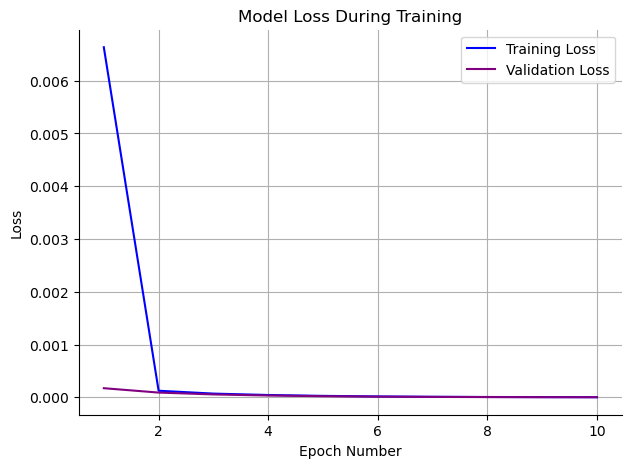

In [47]:
print("Started")
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [12, 8]
model_12_8mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, emg_train_loader, emg_test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.013919345005706418;  Validation Loss: 0.00020546964737966808
Epoch 1: Train Loss: 0.00013482728641065478;  Validation Loss: 8.752805831823118e-05
Epoch 2: Train Loss: 6.348641366002994e-05;  Validation Loss: 4.5843090762845144e-05
Epoch 3: Train Loss: 3.642785652573366e-05;  Validation Loss: 2.9149700098134083e-05
Epoch 4: Train Loss: 2.4595694083018315e-05;  Validation Loss: 2.074797038756292e-05
Epoch 5: Train Loss: 1.7935932908130782e-05;  Validation Loss: 1.542829675005977e-05
Epoch 6: Train Loss: 1.3462515090623128e-05;  Validation Loss: 1.1674818742161437e-05
Epoch 7: Train Loss: 1.0239118483923449e-05;  Validation Loss: 8.924139680801796e-06
Epoch 8: Train Loss: 7.857878455297395e-06;  Validation Loss: 6.87804796533393e-06
Epoch 9: Train Loss: 6.080031215560666e-06;  Validation Loss: 5.345451362310476e-06


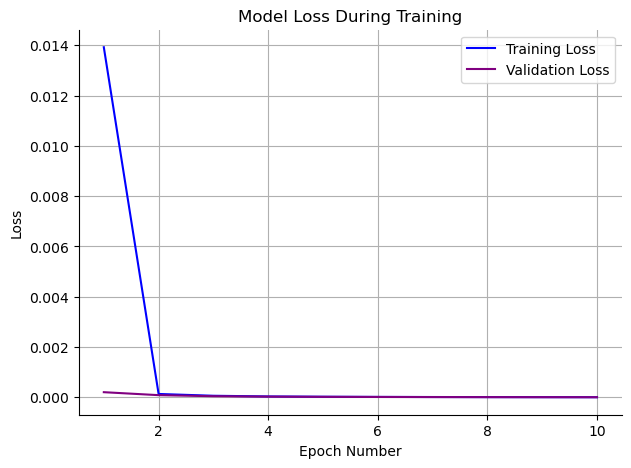

In [48]:
print("Started")
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [8]
model_8mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, emg_train_loader, emg_test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.003202485899100793;  Validation Loss: 8.362274241576693e-05
Epoch 1: Train Loss: 4.30750232567334e-05;  Validation Loss: 1.9536051732590136e-05
Epoch 2: Train Loss: 1.1767512756932774e-05;  Validation Loss: 6.997023969493707e-06
Epoch 3: Train Loss: 5.131720854478772e-06;  Validation Loss: 3.828633647831989e-06
Epoch 4: Train Loss: 3.12914372244677e-06;  Validation Loss: 2.5676888248087883e-06
Epoch 5: Train Loss: 2.1918377306917593e-06;  Validation Loss: 1.865501605273178e-06
Epoch 6: Train Loss: 1.6212394122305796e-06;  Validation Loss: 1.4011661686690416e-06
Epoch 7: Train Loss: 1.229042104000655e-06;  Validation Loss: 1.0717380811391713e-06
Epoch 8: Train Loss: 9.469923291760552e-07;  Validation Loss: 8.322033699075793e-07
Epoch 9: Train Loss: 7.407104522627606e-07;  Validation Loss: 6.56001643573272e-07


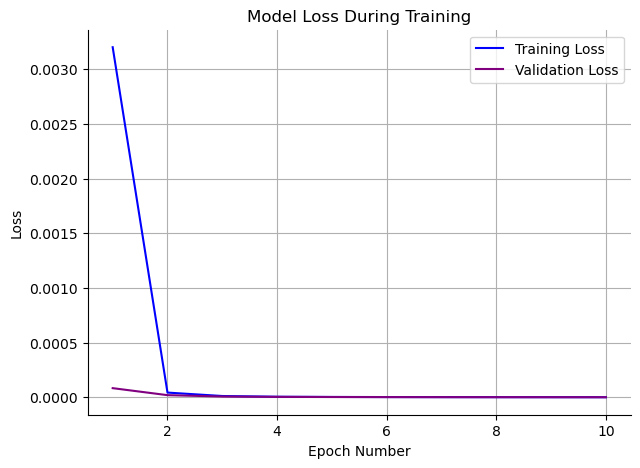

In [49]:
print("Started")
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [12, 6]
model_12_6mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, emg_train_loader, emg_test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.01678245262037308;  Validation Loss: 0.00020976453260471094
Epoch 1: Train Loss: 9.33010656353872e-05;  Validation Loss: 7.136432158200032e-05
Epoch 2: Train Loss: 6.0662198188765613e-05;  Validation Loss: 5.1066105679266765e-05
Epoch 3: Train Loss: 4.372174628315406e-05;  Validation Loss: 3.717294815459707e-05
Epoch 4: Train Loss: 3.2156715394648924e-05;  Validation Loss: 2.766052602964919e-05
Epoch 5: Train Loss: 2.4165589172753245e-05;  Validation Loss: 2.100348717007995e-05
Epoch 6: Train Loss: 1.849873963237769e-05;  Validation Loss: 1.621071228606636e-05
Epoch 7: Train Loss: 1.436814771977879e-05;  Validation Loss: 1.2672245099324476e-05
Epoch 8: Train Loss: 1.1290509524997105e-05;  Validation Loss: 1.0012060148274402e-05
Epoch 9: Train Loss: 8.962526823097506e-06;  Validation Loss: 7.987800259166872e-06


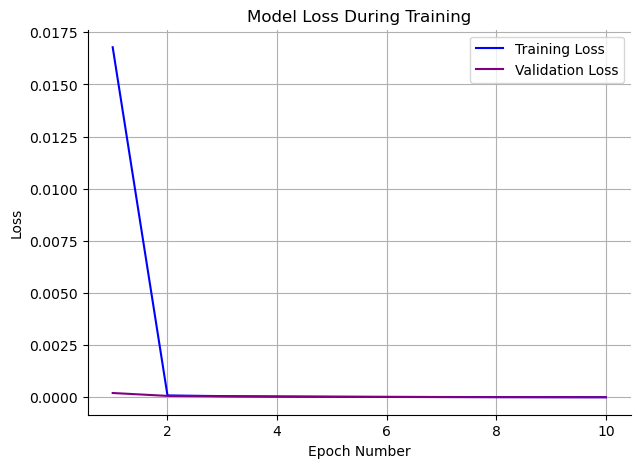

In [50]:
print("Started")
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [6]
model_6mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, emg_train_loader, emg_test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.004924121006479254;  Validation Loss: 0.00017813868804036507
Epoch 1: Train Loss: 0.00012309205276324066;  Validation Loss: 8.254604977175442e-05
Epoch 2: Train Loss: 6.180140428568848e-05;  Validation Loss: 4.56091531342114e-05
Epoch 3: Train Loss: 3.5218088964938946e-05;  Validation Loss: 2.6592192866979642e-05
Epoch 4: Train Loss: 2.0846242091465683e-05;  Validation Loss: 1.6043596235472157e-05
Epoch 5: Train Loss: 1.2802510076426188e-05;  Validation Loss: 1.0069873830931955e-05
Epoch 6: Train Loss: 8.182475247053844e-06;  Validation Loss: 6.566678240808554e-06
Epoch 7: Train Loss: 5.414190388819406e-06;  Validation Loss: 4.411290217608532e-06
Epoch 8: Train Loss: 3.6758781917001214e-06;  Validation Loss: 3.028041558592326e-06
Epoch 9: Train Loss: 2.5443592107876612e-06;  Validation Loss: 2.114787683203016e-06


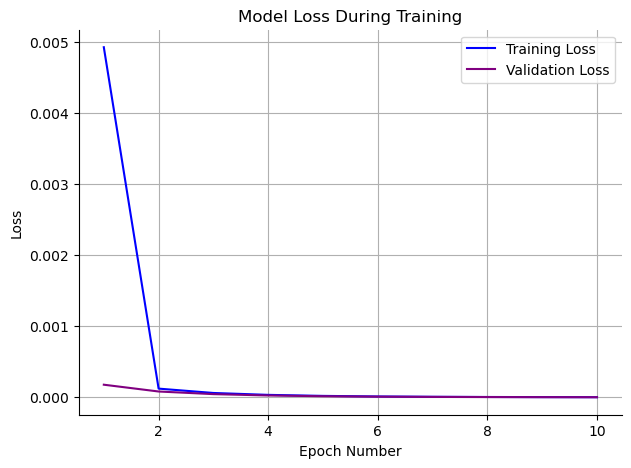

In [51]:
print("Started")
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [12, 7, 3]
model_12_7_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, emg_train_loader, emg_test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.0014682160330721672;  Validation Loss: 0.00011422910637873206
Epoch 1: Train Loss: 7.915483913620847e-05;  Validation Loss: 5.2879485467981014e-05
Epoch 2: Train Loss: 3.822643103603696e-05;  Validation Loss: 2.683170391626808e-05
Epoch 3: Train Loss: 2.0017948901340788e-05;  Validation Loss: 1.4566950809165399e-05
Epoch 4: Train Loss: 1.1140827962208277e-05;  Validation Loss: 8.340520661458497e-06
Epoch 5: Train Loss: 6.506011462192873e-06;  Validation Loss: 4.976435589849978e-06
Epoch 6: Train Loss: 3.9348760282109655e-06;  Validation Loss: 3.050494087244947e-06
Epoch 7: Train Loss: 2.4295132263318918e-06;  Validation Loss: 1.8956468280446977e-06
Epoch 8: Train Loss: 1.5151849453332033e-06;  Validation Loss: 1.186545664588303e-06
Epoch 9: Train Loss: 9.522275536966163e-07;  Validation Loss: 7.49550438007534e-07


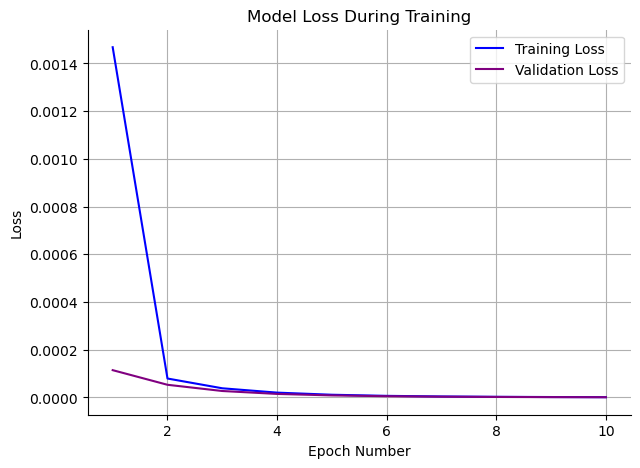

In [52]:
print("Started")
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [12, 3]
model_12_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, emg_train_loader, emg_test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.05512894049170427;  Validation Loss: 0.013013569372040885
Epoch 1: Train Loss: 0.004428390113389469;  Validation Loss: 0.0007153426746039518
Epoch 2: Train Loss: 0.00028253362916075275;  Validation Loss: 0.00013345044358082267
Epoch 3: Train Loss: 0.00011286964968348911;  Validation Loss: 9.7613492731138e-05
Epoch 4: Train Loss: 8.564580734855553e-05;  Validation Loss: 7.43571485034e-05
Epoch 5: Train Loss: 6.476580263097276e-05;  Validation Loss: 5.579677473383062e-05
Epoch 6: Train Loss: 4.8317081359527946e-05;  Validation Loss: 4.138155173324999e-05
Epoch 7: Train Loss: 3.5689013498085845e-05;  Validation Loss: 3.0449291629412648e-05
Epoch 8: Train Loss: 2.621111657390429e-05;  Validation Loss: 2.2337136011183432e-05
Epoch 9: Train Loss: 1.9248090404744288e-05;  Validation Loss: 1.6443698471875347e-05


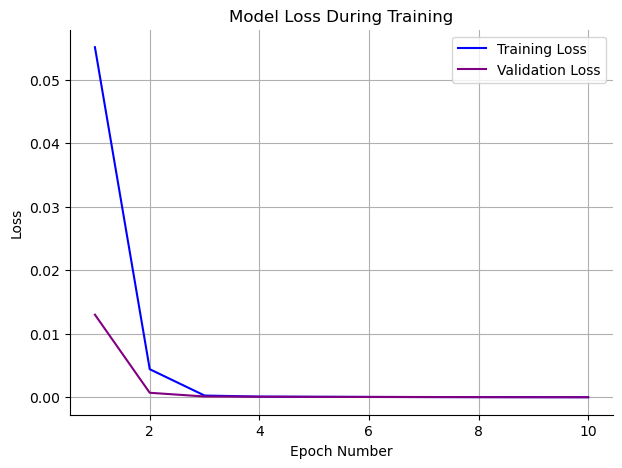

In [53]:
print("Started")
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [3]
model_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, emg_train_loader, emg_test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

## Visual Inspection of Reconstructed VS Original Signals

Average testing loss across the entire test_loader: 3.8567752572557114e-07


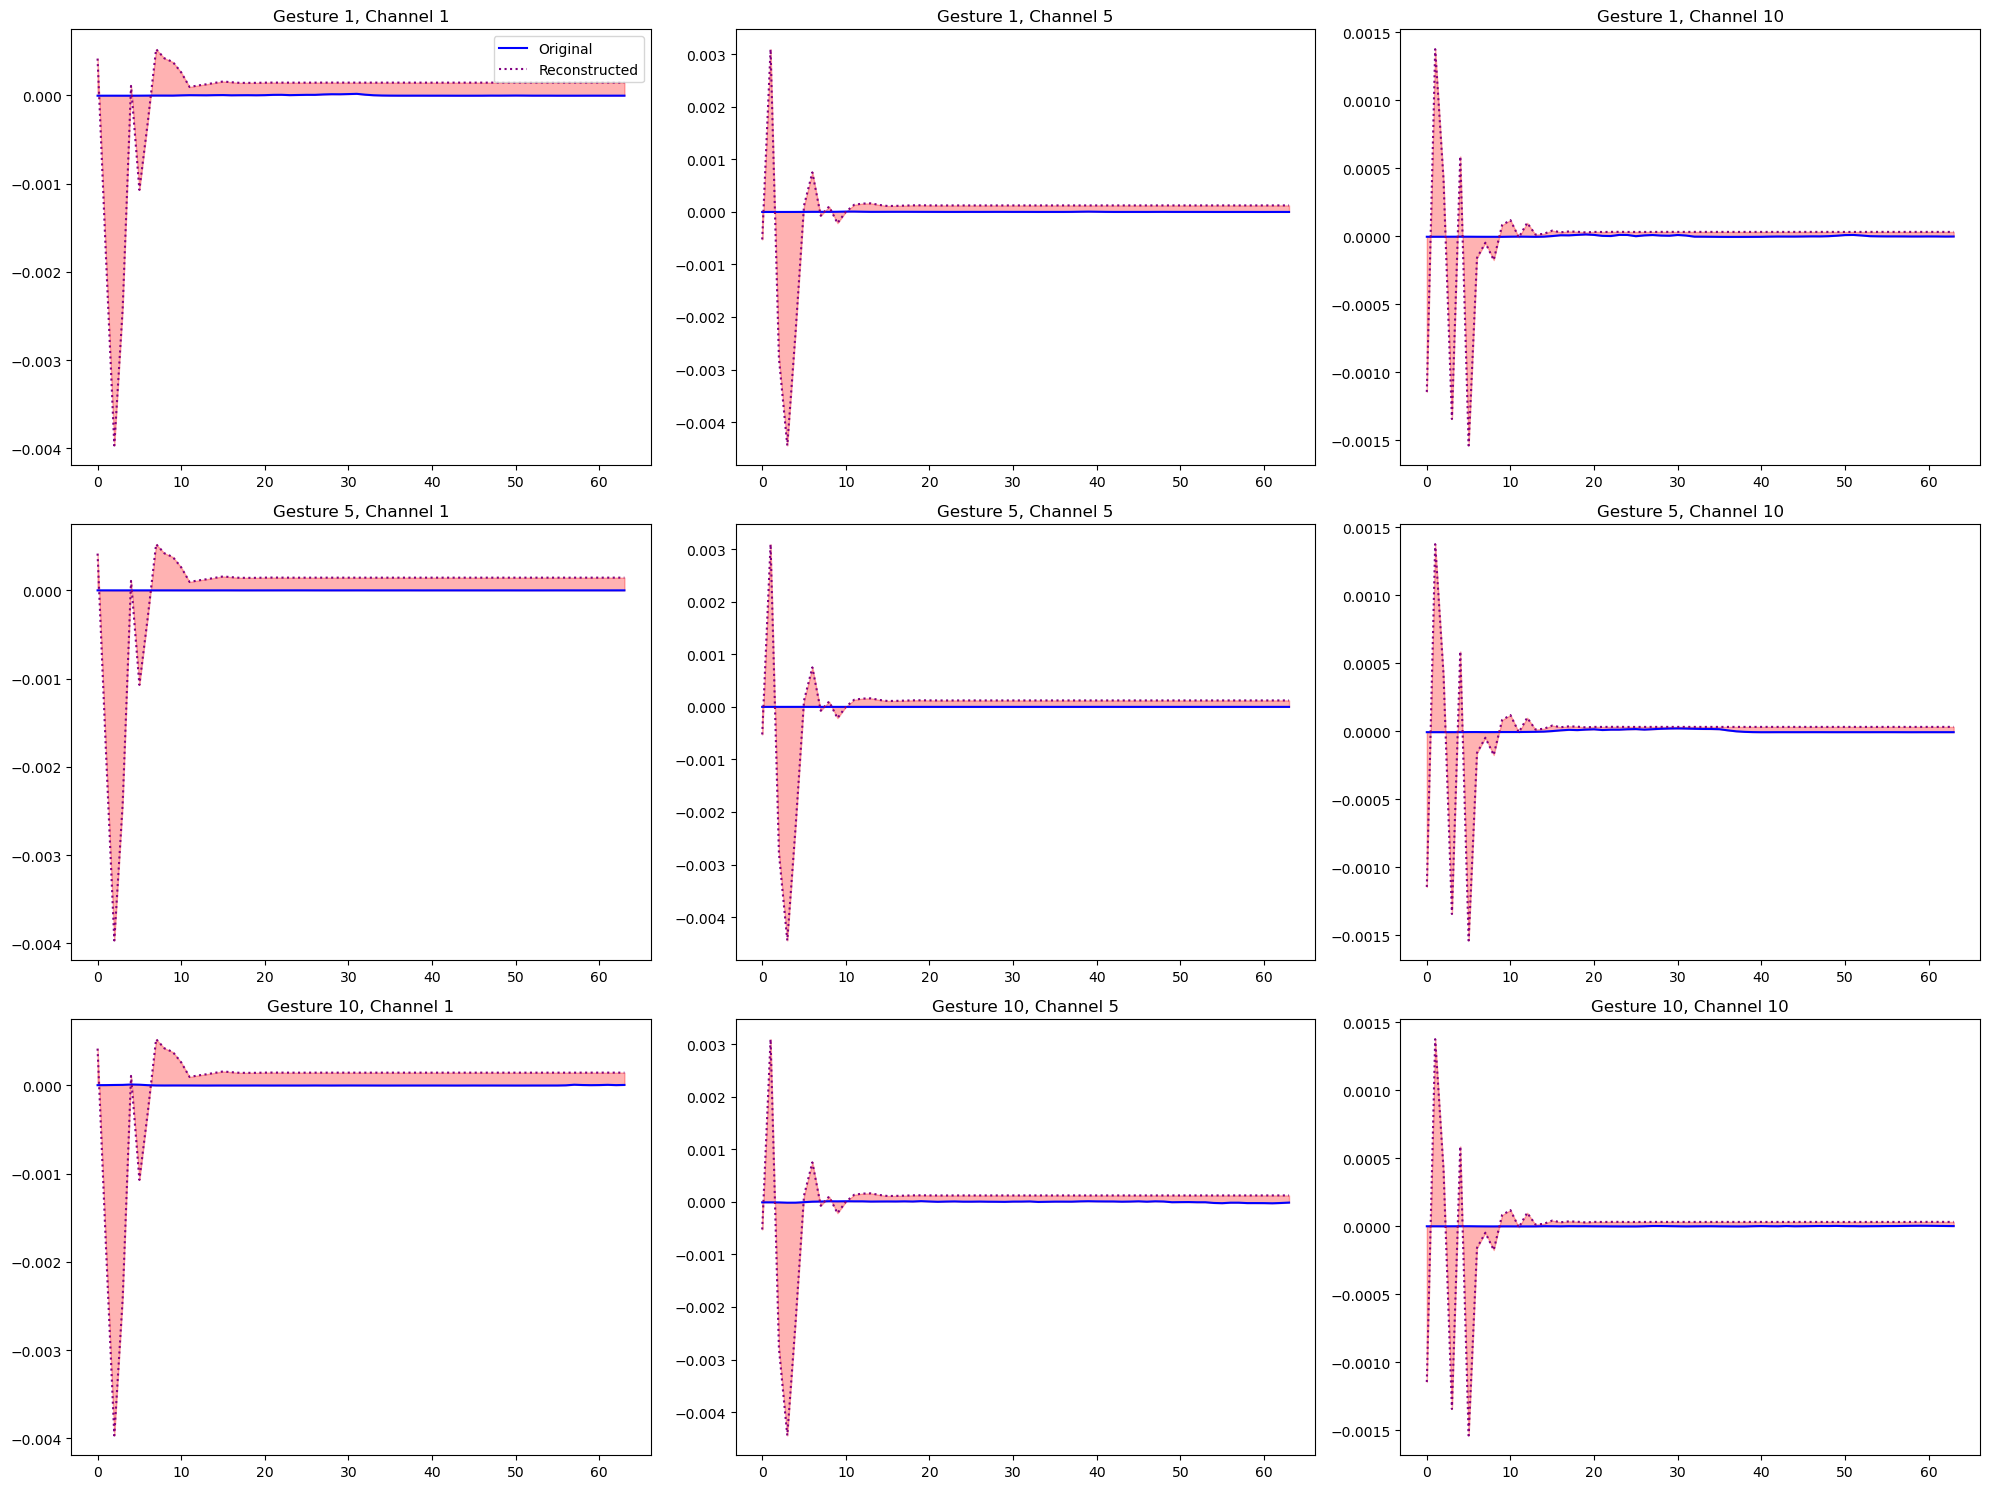

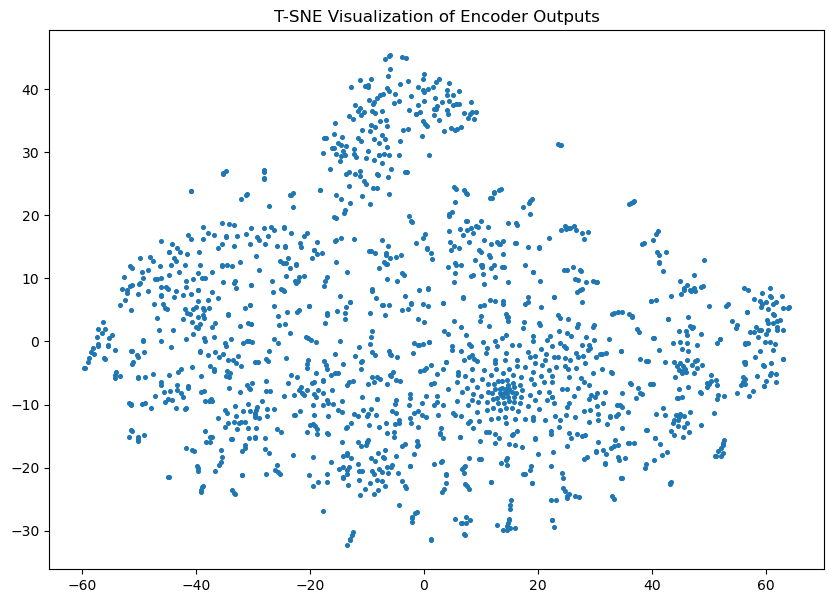

Explained variance by each principal component: [0.29019463 0.11637255]
Total explained variance: 0.4066


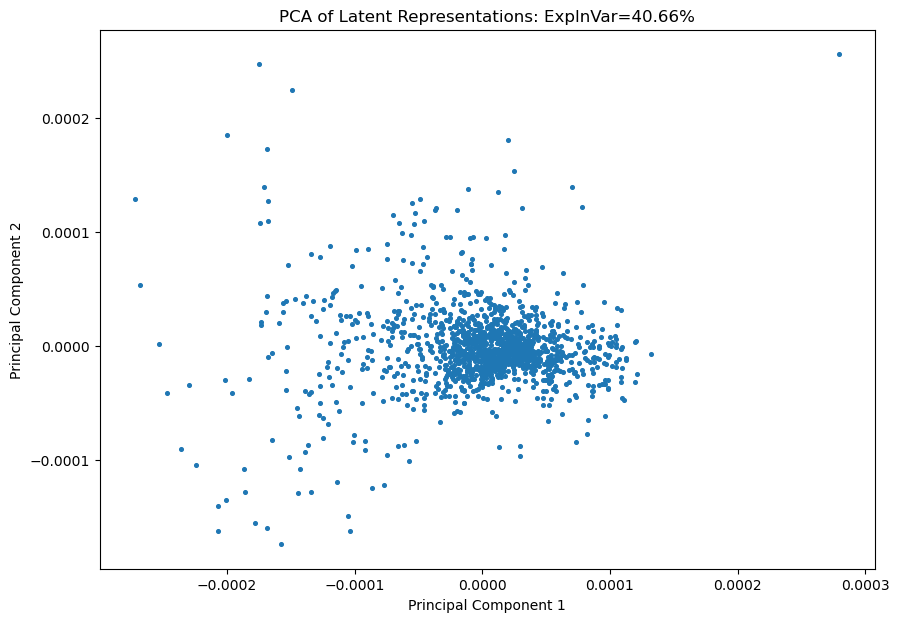

In [56]:
my_model = model_20_10_3mir

average_test_loss, sample_data_lst, reconstructions_lst, latent_representations_lst = eval_on_testset_and_return_original_and_reconstructed(my_model, emg_test_loader)
visualize_original_vs_reconstructed_gestures(sample_data_lst[0], reconstructions_lst[0], selected_gestures=[1, 5, 10], selected_channels=[1, 5, 10])
latent_space_vis(latent_representations_lst)

Average testing loss across the entire test_loader: 5.933179624885177e-07


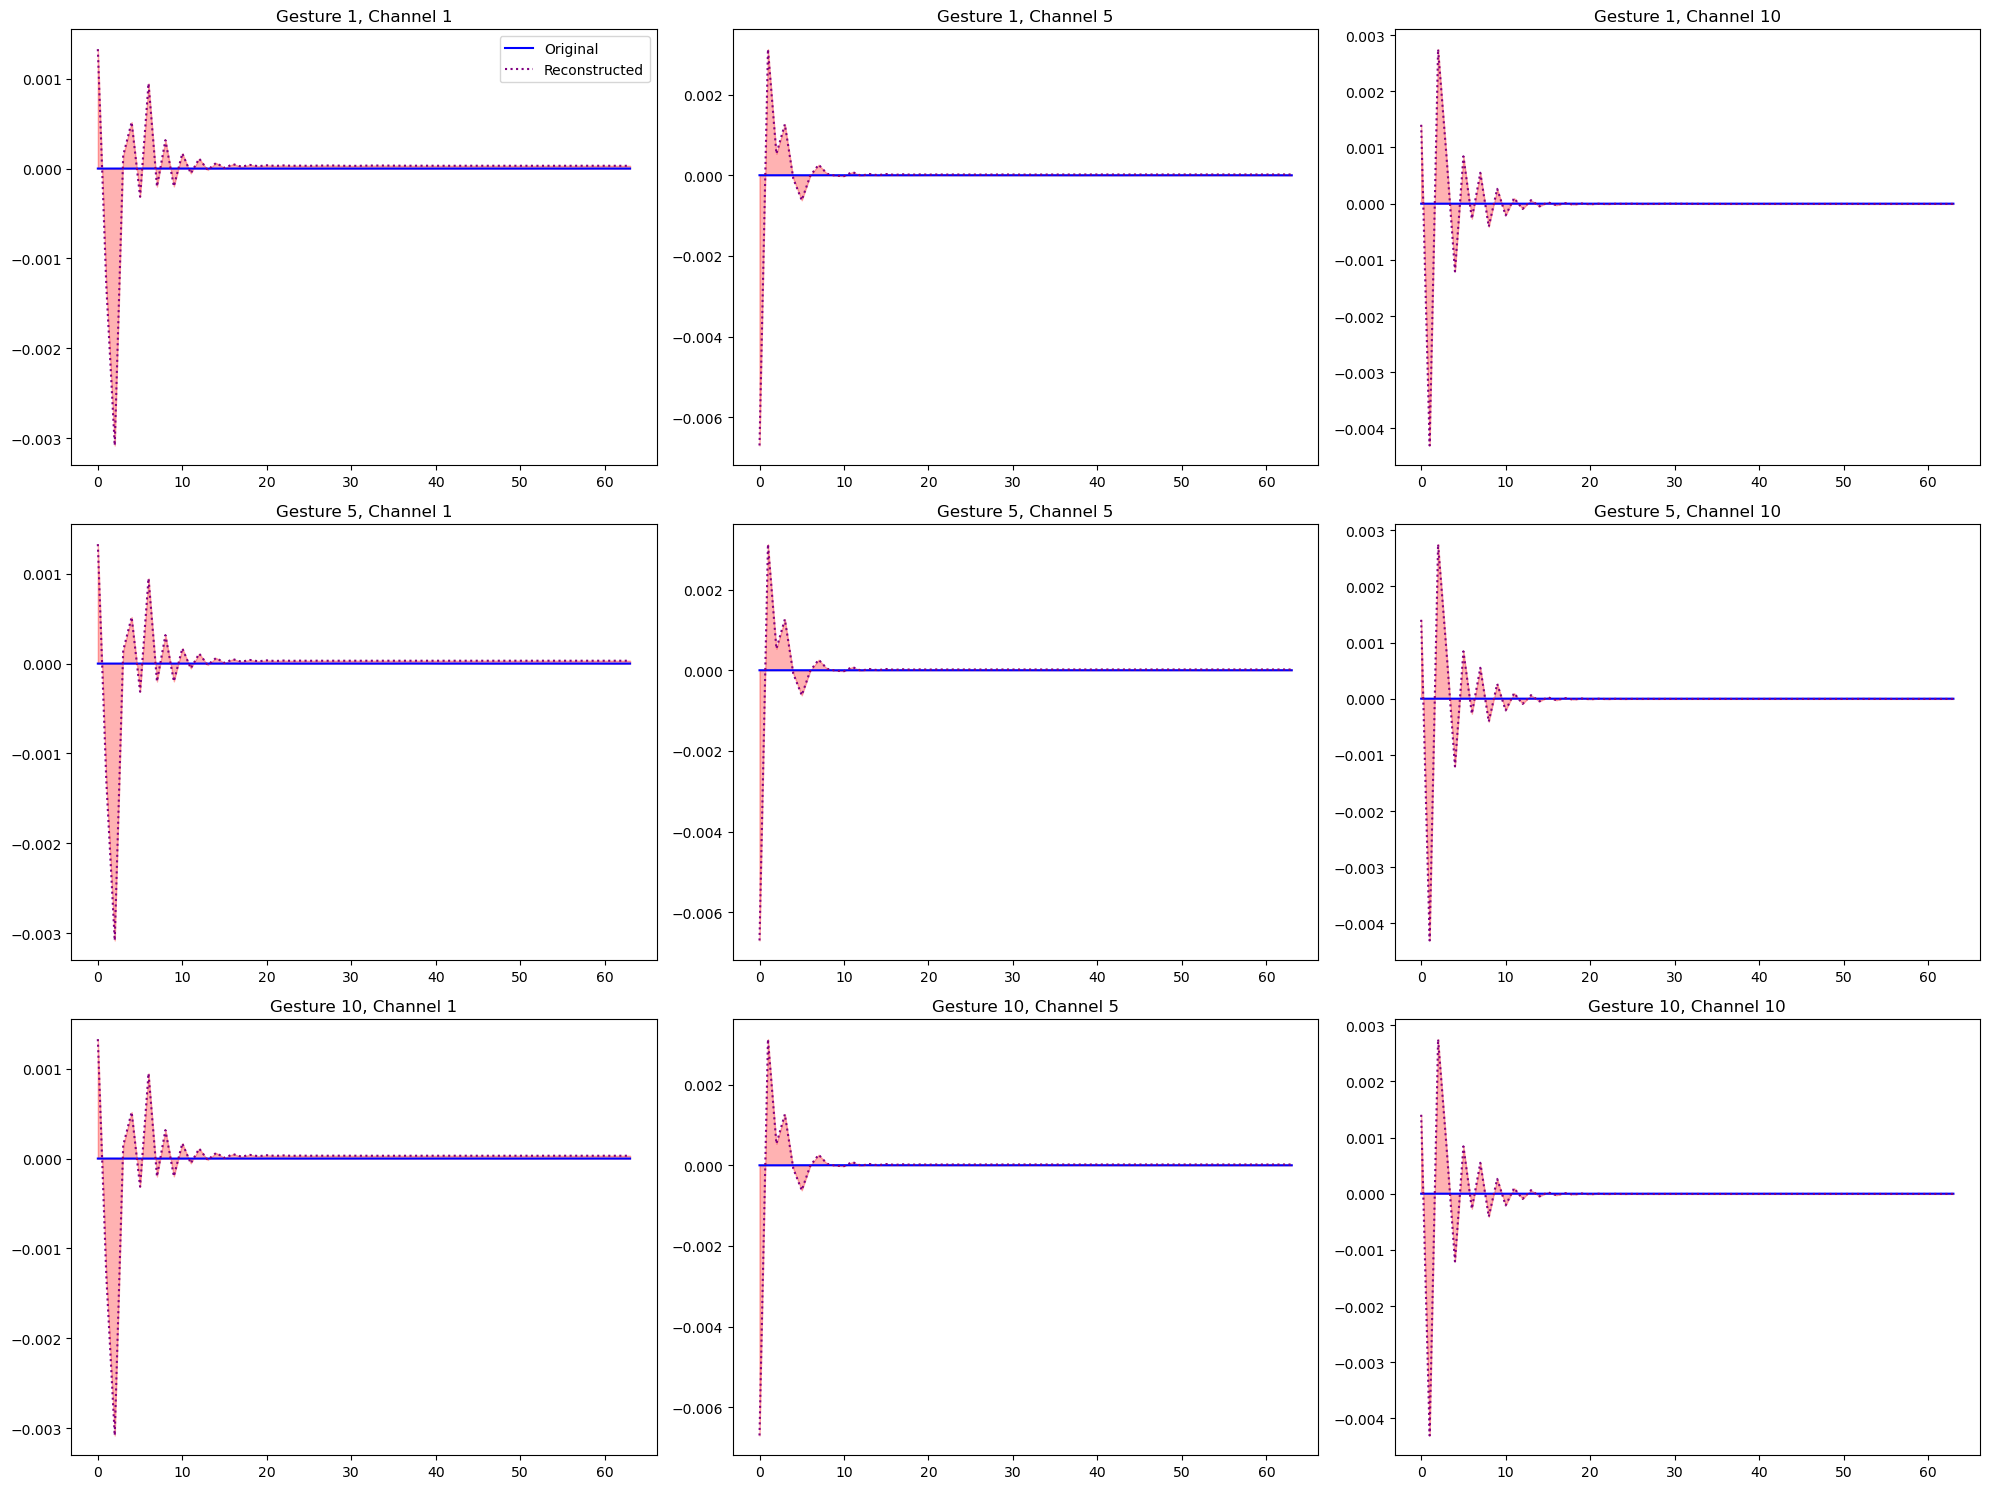

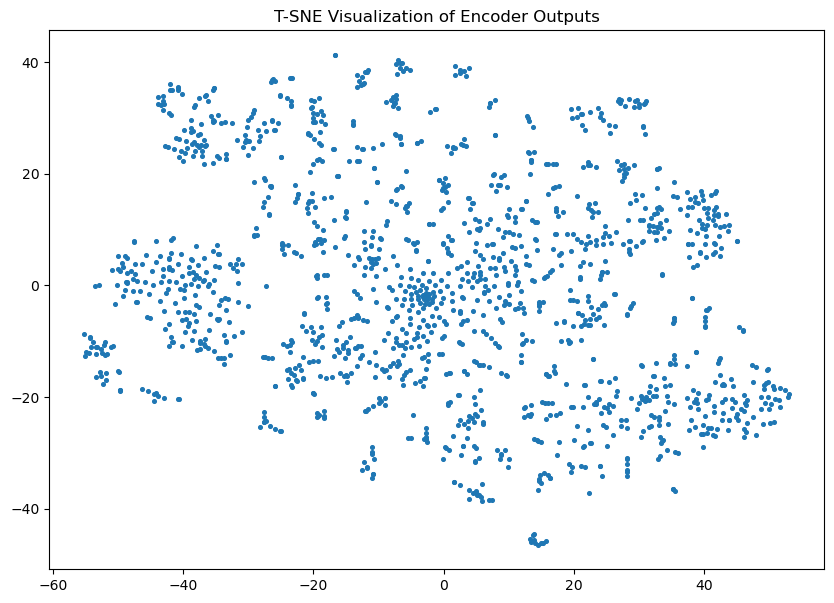

Explained variance by each principal component: [0.19296551 0.06717144]
Total explained variance: 0.2601


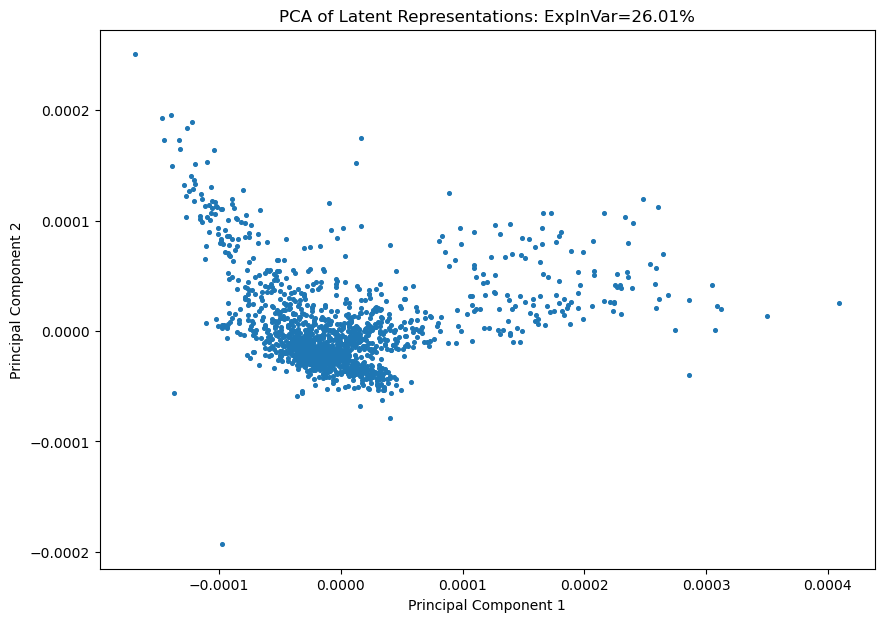

In [57]:
my_model = model_20_10mir

average_test_loss, sample_data_lst, reconstructions_lst, latent_representations_lst = eval_on_testset_and_return_original_and_reconstructed(my_model, emg_test_loader)
visualize_original_vs_reconstructed_gestures(sample_data_lst[0], reconstructions_lst[0], selected_gestures=[1, 5, 10], selected_channels=[1, 5, 10])
latent_space_vis(latent_representations_lst)

In [ ]:
assert(False)

Average testing loss across the entire test_loader: 0.15363889586950216


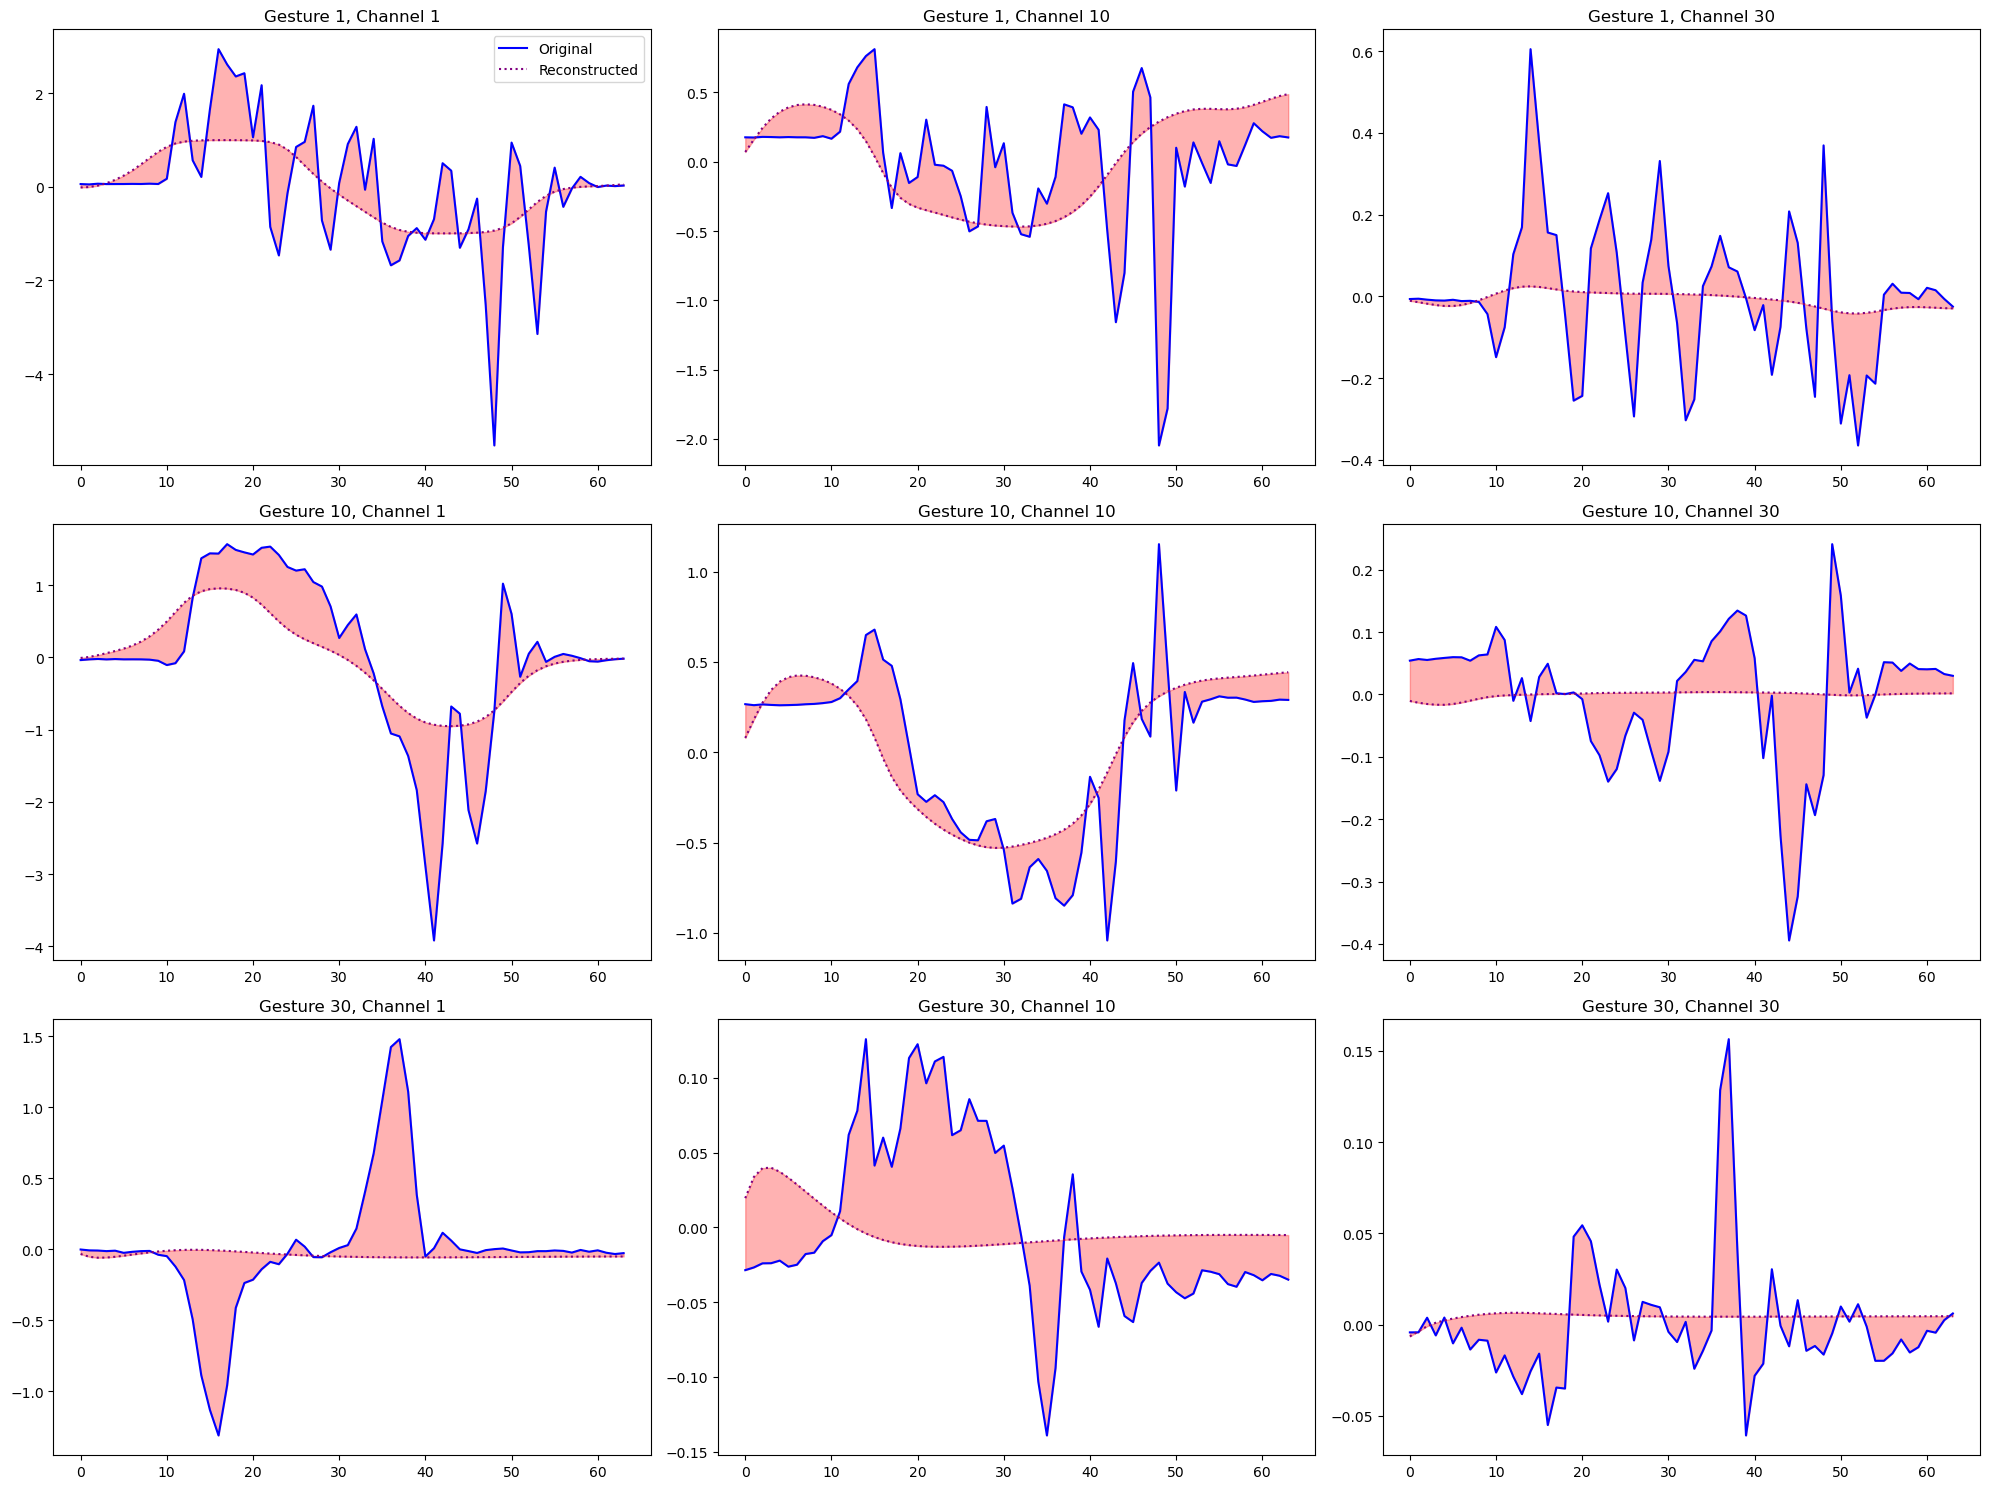

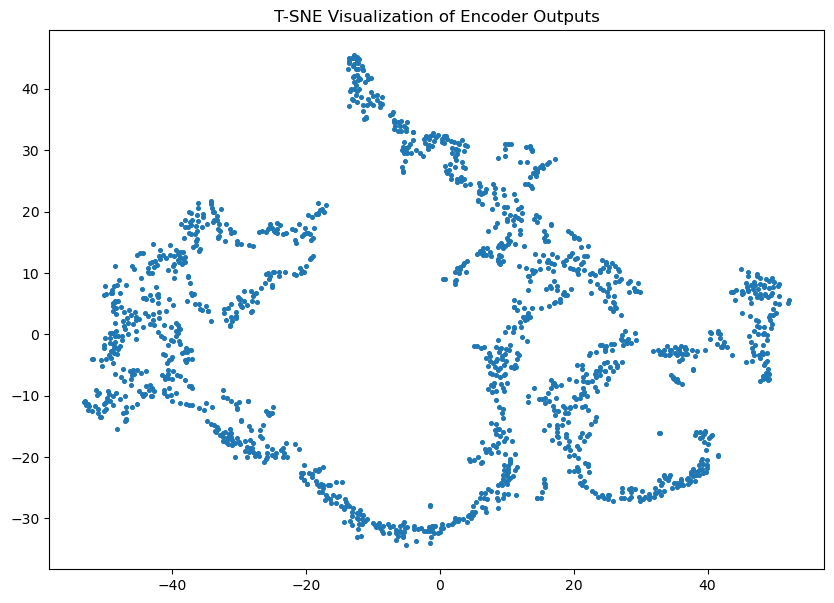

Explained variance by each principal component: [0.7402424 0.2157994]
Total explained variance: 0.9560


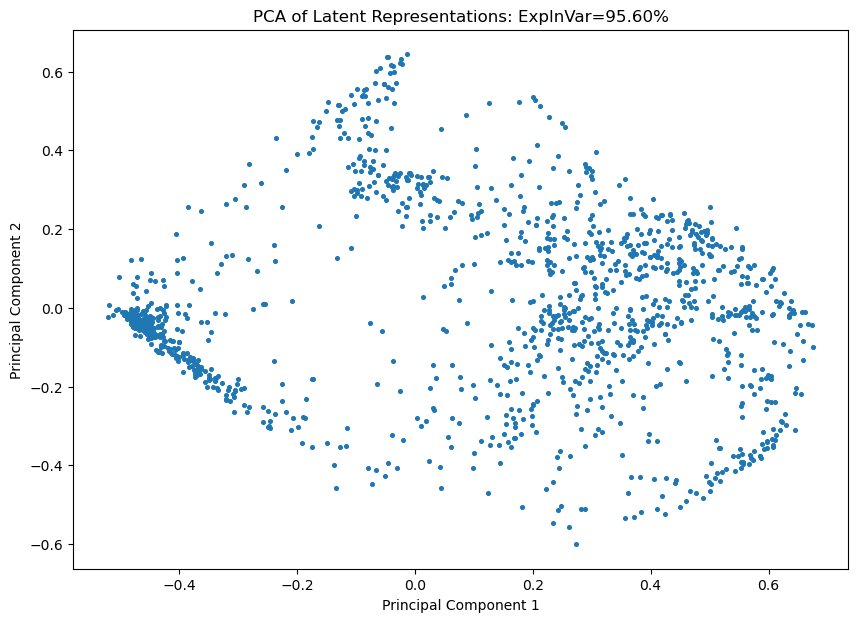

In [19]:
my_model = RNNAE_latent3_BothPCA40_model

average_test_loss, sample_data_lst, reconstructions_lst, latent_representations_lst = eval_on_testset_and_return_original_and_reconstructed(my_model, test_loader)
visualize_original_vs_reconstructed_gestures(sample_data_lst[0], reconstructions_lst[0])
latent_space_vis(latent_representations_lst)

Average testing loss across the entire test_loader: 0.14386780854618672


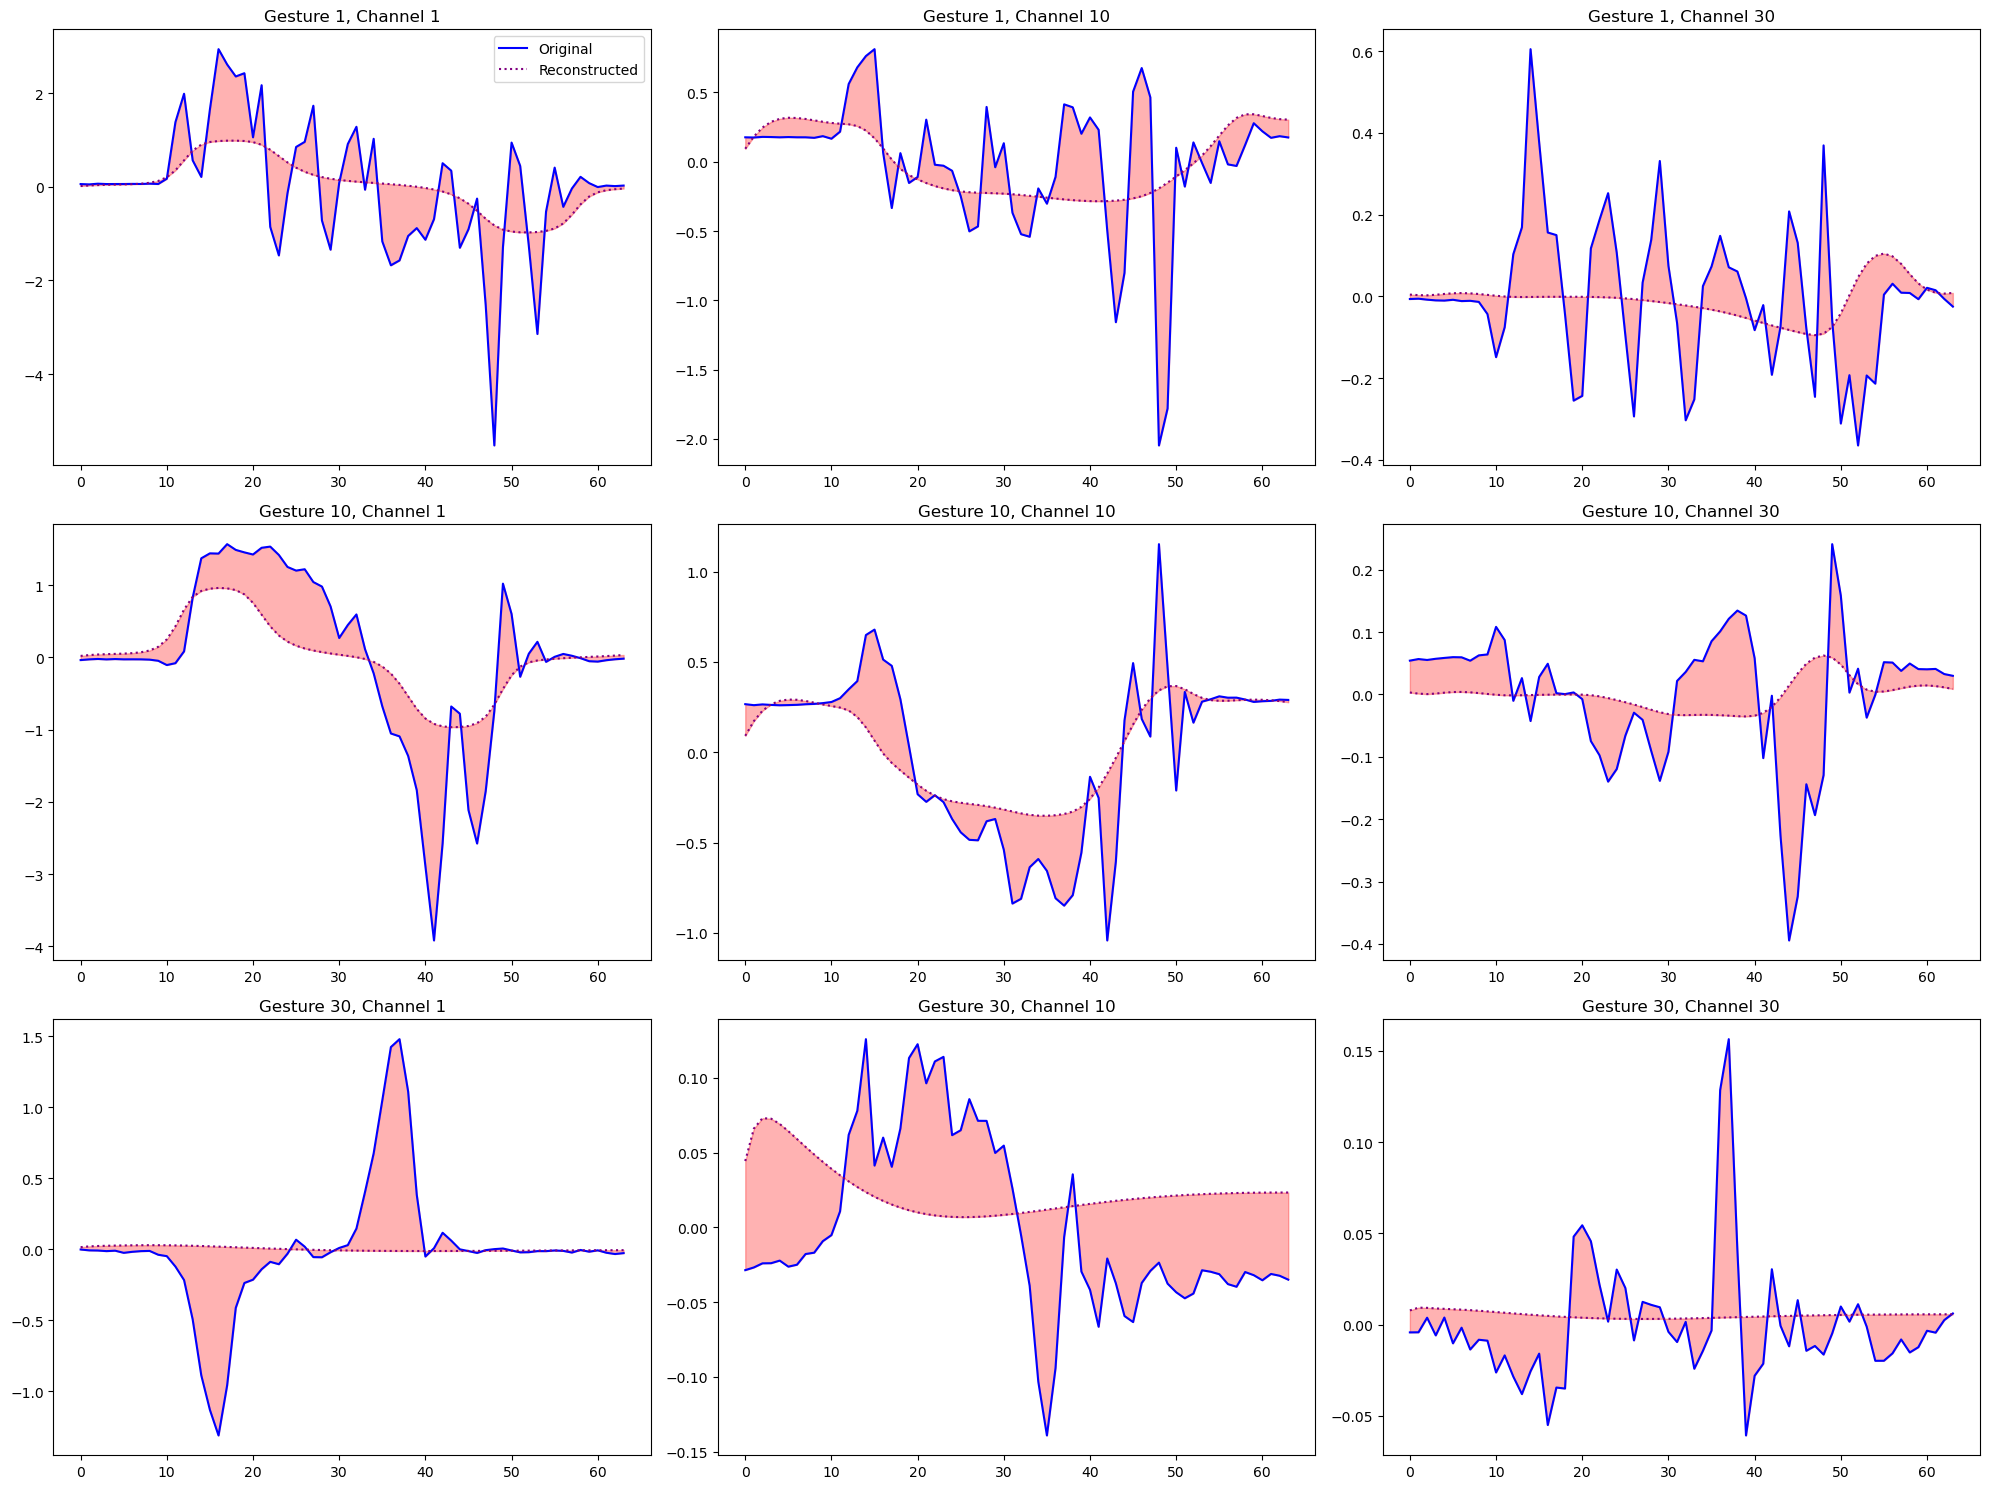

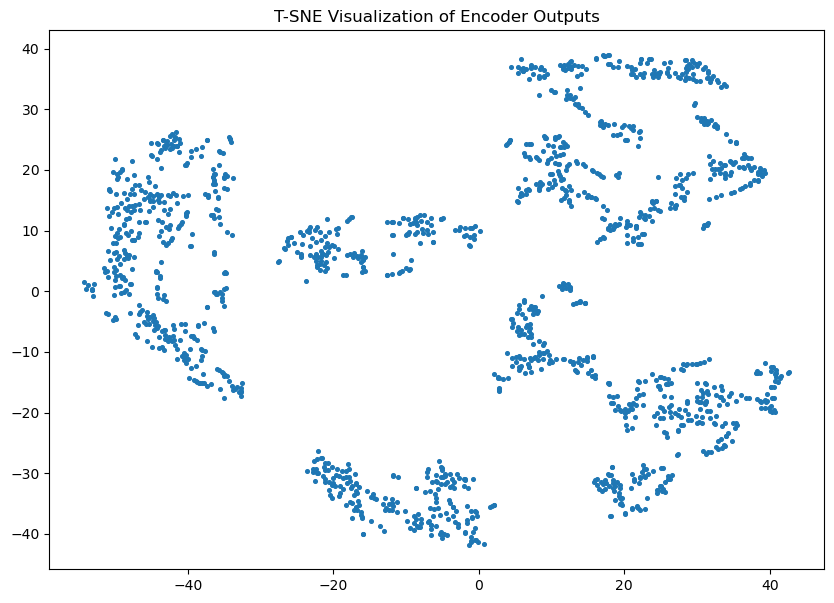

Explained variance by each principal component: [0.4928481  0.23890398]
Total explained variance: 0.7318


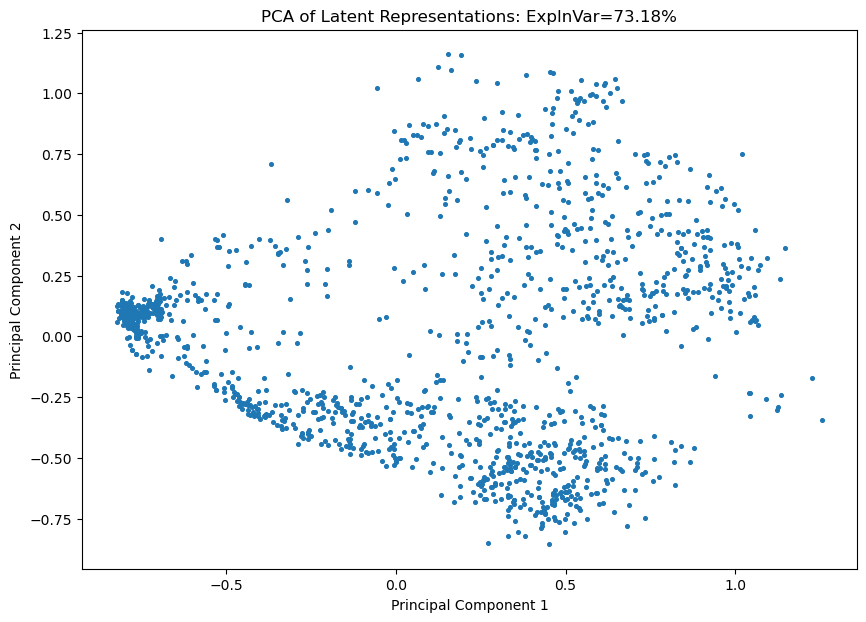

In [20]:
my_model = RNNAE_latent12_BothPCA40_model

average_test_loss, sample_data_lst, reconstructions_lst, latent_representations_lst = eval_on_testset_and_return_original_and_reconstructed(my_model, test_loader)
visualize_original_vs_reconstructed_gestures(sample_data_lst[0], reconstructions_lst[0])
latent_space_vis(latent_representations_lst)

Average testing loss across the entire test_loader: 0.0017131721086079037


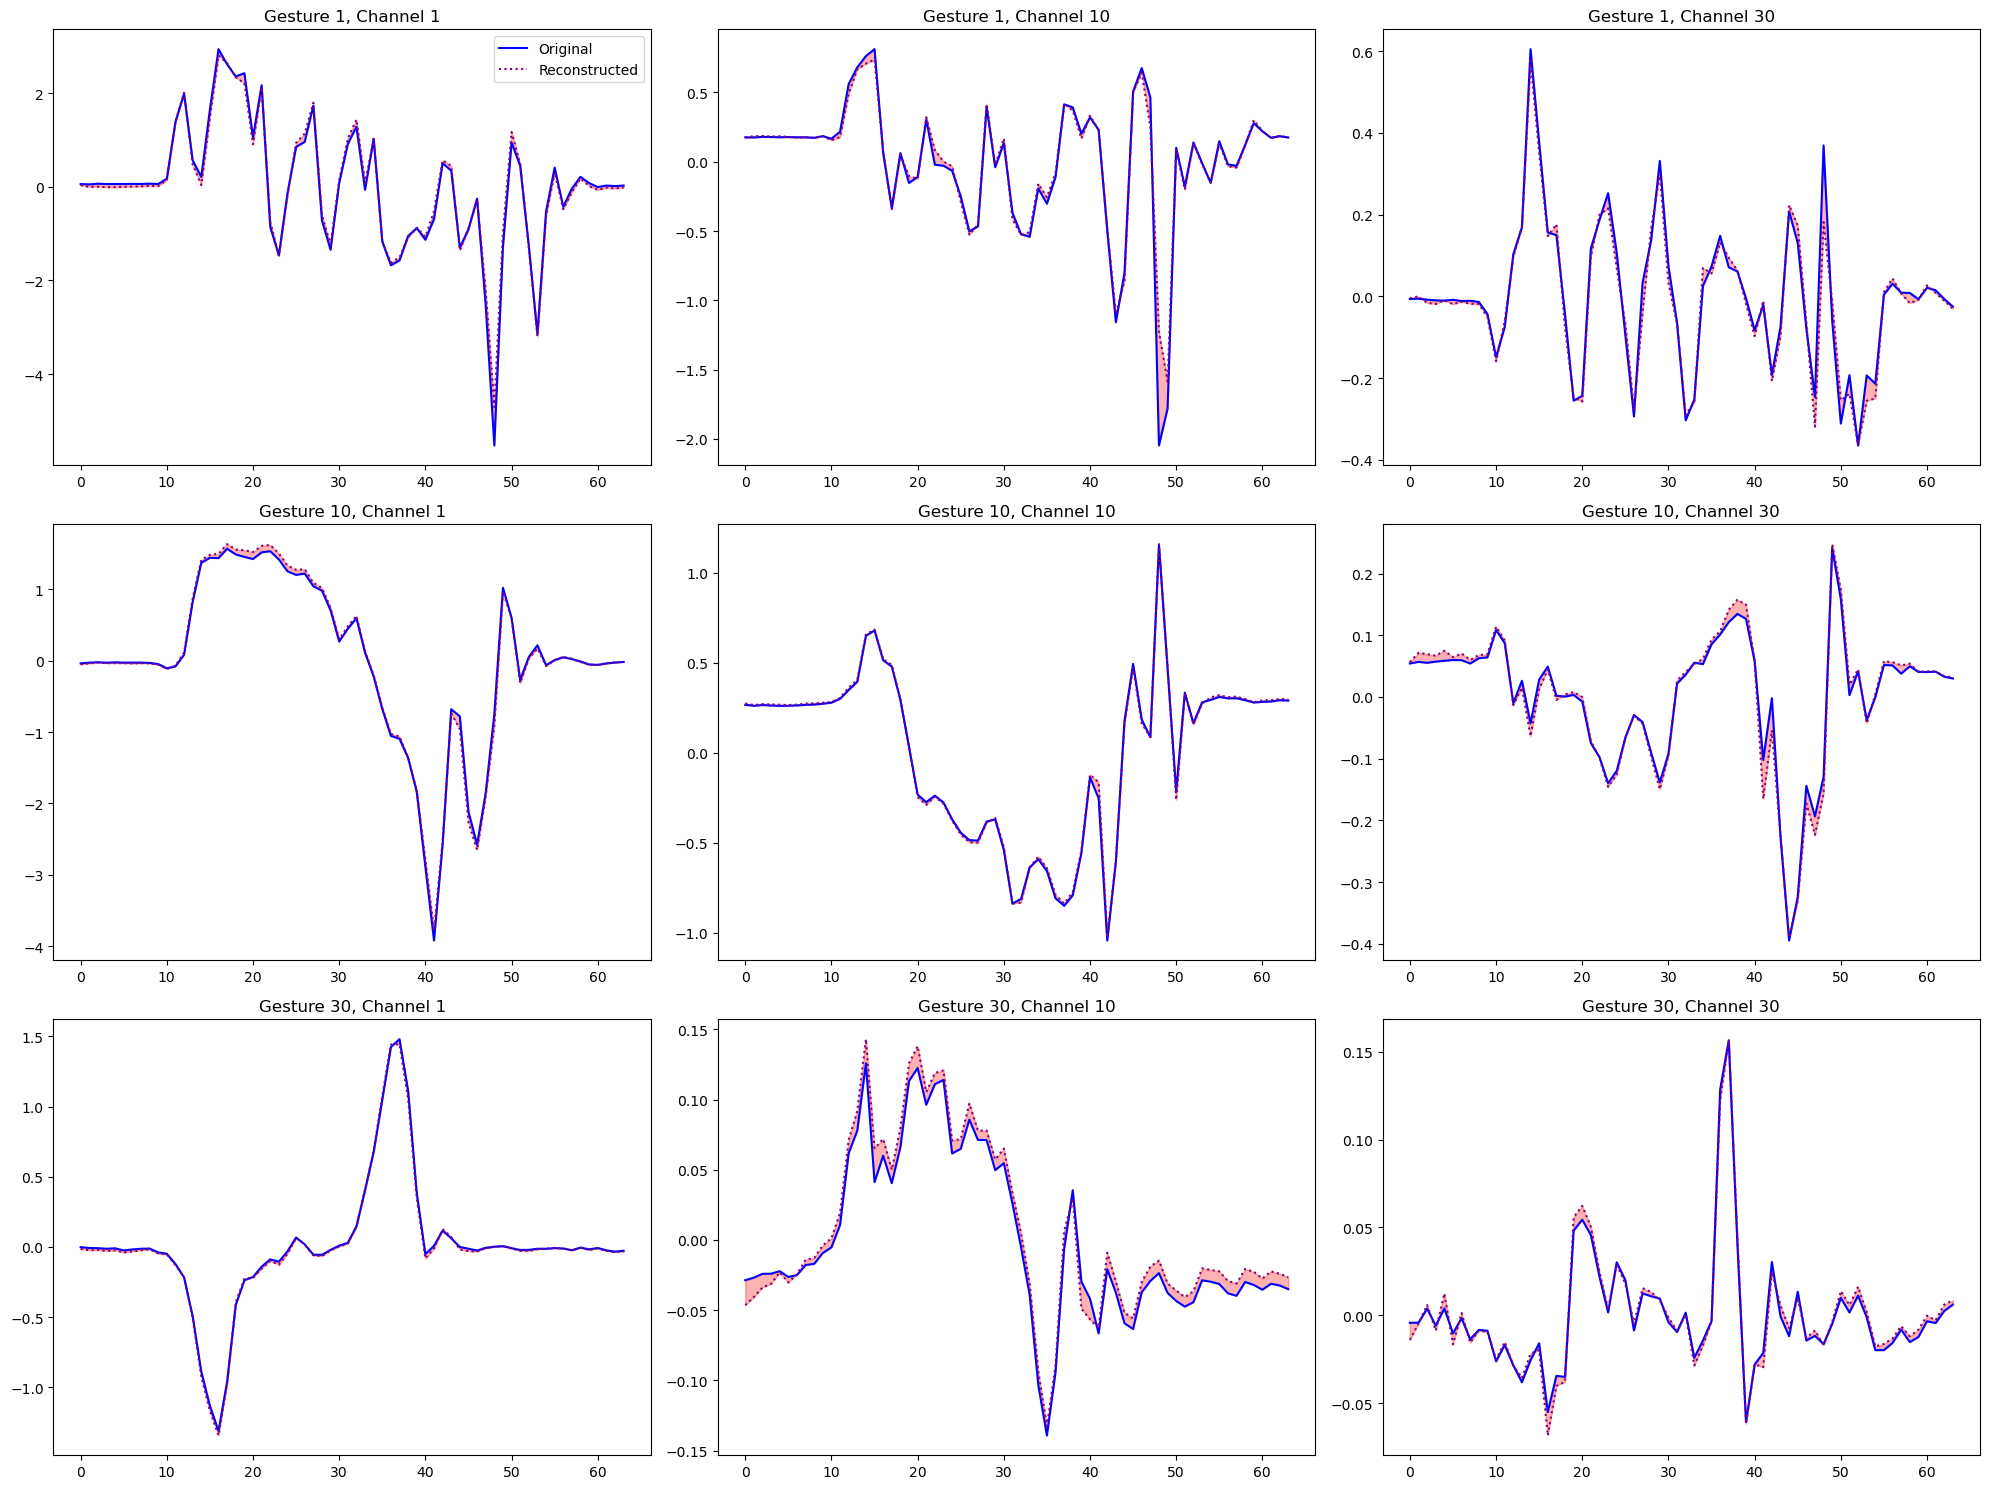

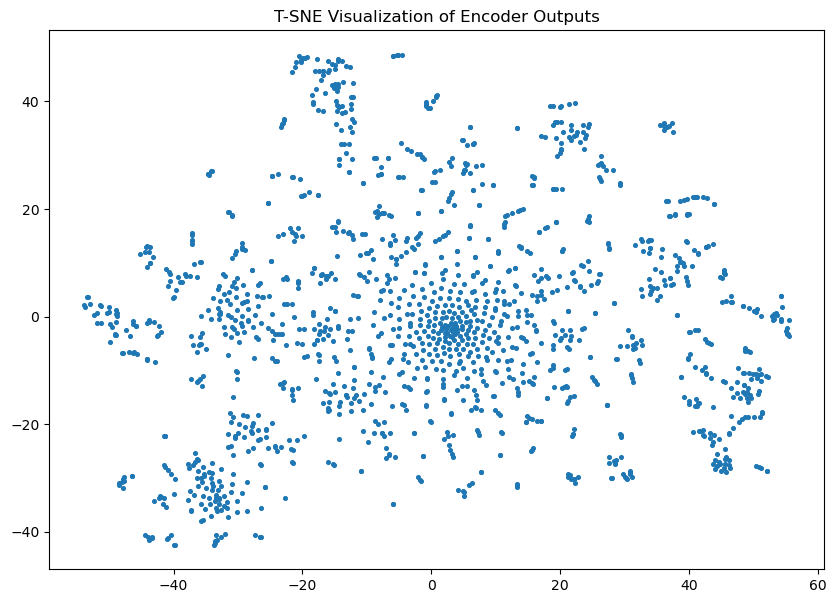

Explained variance by each principal component: [0.07483003 0.04933486]
Total explained variance: 0.1242


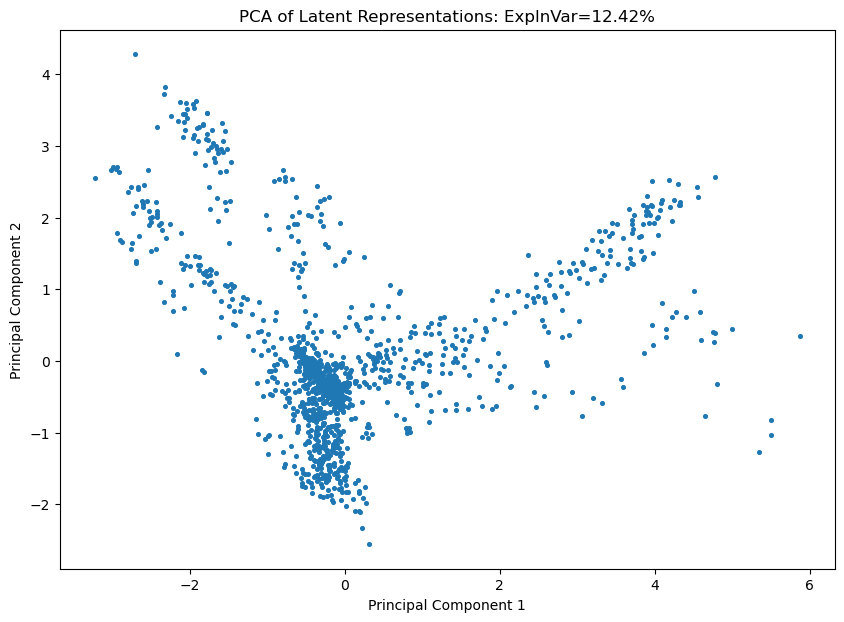

In [21]:
my_model = RNNAE_gridsearch_latent128_BothPCA40_model

average_test_loss, sample_data_lst, reconstructions_lst, latent_representations_lst = eval_on_testset_and_return_original_and_reconstructed(my_model, test_loader)
visualize_original_vs_reconstructed_gestures(sample_data_lst[0], reconstructions_lst[0])
latent_space_vis(latent_representations_lst)

## Latent Space Clustering

In [ ]:
# Maximum number of components
max_clusters = 12
num_clusters_range = list(range(2, max_clusters+1))

In [ ]:
km_silhouette_lst=[]
km_davies_bouldin_lst=[]
km_cali_har_lst=[]
km_dunn_index_lst=[]
km_gap_stat_lst=[]
for n in num_clusters_range:
    print(f"{n}/{num_clusters_range[-1]}")
    silhouette, db_index, ch_index, di_index, gap_stat = run_clustering_algorithm('KMeans', latent_representations_reshaped, num_clusters=n)
    km_silhouette_lst.append(silhouette)
    km_davies_bouldin_lst.append(db_index)
    km_cali_har_lst.append(ch_index)
    km_dunn_index_lst.append(di_index)
    km_gap_stat_lst.append(gap_stat)

In [ ]:
plt.plot(num_clusters_range, km_silhouette_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('KMeans Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.show()

In [ ]:
plt.plot(num_clusters_range, km_davies_bouldin_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies Bouldin Score')
plt.title('KMeans Davies Bouldin Score vs Number of Clusters')
plt.grid(True)
plt.show()

In [ ]:
plt.plot(num_clusters_range, km_cali_har_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski Harabasz Score')
plt.title('KMeans Calinski Harabasz Score vs Number of Clusters')
plt.grid(True)
plt.show()

In [ ]:
plt.plot(num_clusters_range, km_dunn_index_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Dunn Index')
plt.title('KMeans Dunn Index vs Number of Clusters')
plt.grid(True)
plt.show()

In [ ]:
plt.plot(num_clusters_range, km_gap_stat_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Gap Index')
plt.title('KMeanz Gap Index vs Number of Clusters')
plt.grid(True)
plt.show()